In [44]:
import geopandas
import numpy
import rioxarray
import xarray as xr
import os
import cftime
import matplotlib.pyplot as plt
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from geocube.api.core import make_geocube
import pandas as pd
import glob

In [2]:
if not os.path.isfile('./data/precip_all.nc'):
    precip_0 = xr.open_dataset('./data/data_0.nc')
    precip_1 = xr.open_dataset('./data/data_1.nc')
    precip_full = xr.concat([precip_0, precip_1], dim='valid_time')
    precip_full = precip_full.sortby('valid_time')
    precip_full[['tp']].to_netcdf('./data/precip_all.nc')

# Regional data

In [3]:
biome_gdf = geopandas.read_file('../regions/data/lm_bioma_250.shp').to_crs('EPSG:4326')

In [4]:
precip_reg_full = rioxarray.open_rasterio(
    "./data/precip_all.nc", masked=True
)
precip_reg_full.rio.write_crs(4326, inplace=True)
precip_reg_clip = precip_reg_full.rio.clip(
    biome_gdf.geometry.values, biome_gdf.crs, from_disk=True
)

In [5]:
out_grid_reg = make_geocube(
    vector_data=biome_gdf,
    measurements=["CD_Bioma"],
    like=precip_reg_clip, # ensure the data are on the same grid
)

In [6]:
out_grid_reg["tp"] = (precip_reg_clip.dims, precip_reg_clip.values, precip_reg_clip.attrs, precip_reg_clip.encoding)

In [7]:
out_grid_reg

<xarray.Dataset>
Dimensions:      (y: 392, x: 411, valid_time: 898)
Coordinates:
  * y            (y) float64 5.3 5.2 5.1 5.0 4.9 ... -33.5 -33.6 -33.7 -33.8
  * x            (x) float64 -74.0 -73.9 -73.8 -73.7 ... -33.3 -33.2 -33.1 -33.0
    spatial_ref  int64 0
Dimensions without coordinates: valid_time
Data variables:
    CD_Bioma     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    tp           (valid_time, y, x) float32 nan nan nan nan ... nan nan nan nan

In [8]:

out_grid_reg['valid_time'] = precip_reg_clip['valid_time']

out_grid_reg =out_grid_reg.sortby('valid_time')
out_grid_reg_rainy_offset = out_grid_reg.copy()
# out_grid_reg_rainy_offset['valid_time'] = (out_grid_reg.indexes['valid_time'].to_datetimeindex() + pd.DateOffset(months=+8)).values

In [9]:
out_grid_reg_rainy_offset

<xarray.Dataset>
Dimensions:      (y: 392, x: 411, valid_time: 898)
Coordinates:
  * y            (y) float64 5.3 5.2 5.1 5.0 4.9 ... -33.5 -33.6 -33.7 -33.8
  * x            (x) float64 -74.0 -73.9 -73.8 -73.7 ... -33.3 -33.2 -33.1 -33.0
    spatial_ref  int64 0
  * valid_time   (valid_time) object 1950-01-01 00:00:00 ... 2024-10-01 00:00:00
Data variables:
    CD_Bioma     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    tp           (valid_time, y, x) float32 nan nan nan nan ... nan nan nan nan

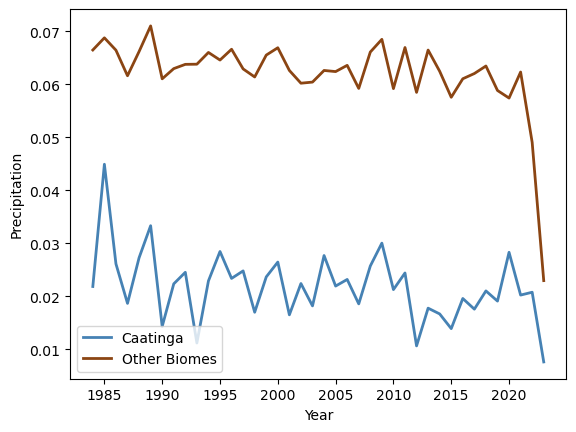

In [13]:
out_grid_reg_rainy_offset.where(
        out_grid_reg_rainy_offset.CD_Bioma==2
    ).mean(
        dim=['x', 'y']
    )['tp'].groupby(
        'valid_time.year'
    ).sum(
        'valid_time'
    ).sel(
        year=slice(1984,2023)
    ).plot.line(
        x='year', color='steelblue', lw=2.0, label='Caatinga')
out_grid_reg_rainy_offset.where(
        out_grid_reg_rainy_offset.CD_Bioma!=2
    ).mean(
        dim=['x', 'y']
    )['tp'].groupby(
        'valid_time.year'
    ).sum(
        'valid_time'
    ).sel(
        year=slice(1984,2023)
    ).plot.line(x='year', color='saddlebrown', lw=2, label='Other Biomes')
plt.xlabel('Year')
plt.ylabel('Precipitation')
plt.legend(loc='lower left')

In [ ]:
# grouped_tp_reg = out_grid_reg.drop("spatial_ref").groupby(out_grid_reg.CD_Bioma).mean()


In [89]:
grouped_tp_reg['valid_time'] = precip_reg_clip['valid_time']

grouped_tp_reg =grouped_tp_reg.sortby('valid_time')
grouped_tp_reg_rainy_offset = grouped_tp_reg.copy()
grouped_tp_reg_rainy_offset['valid_time'] = (grouped_tp_reg.indexes['valid_time'].to_datetimeindex() + pd.DateOffset(months=+8)).values

/home/ksolvik/miniconda3/envs/resgis/lib/python3.10/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


In [ ]:
mean_except_bioma2 = precip

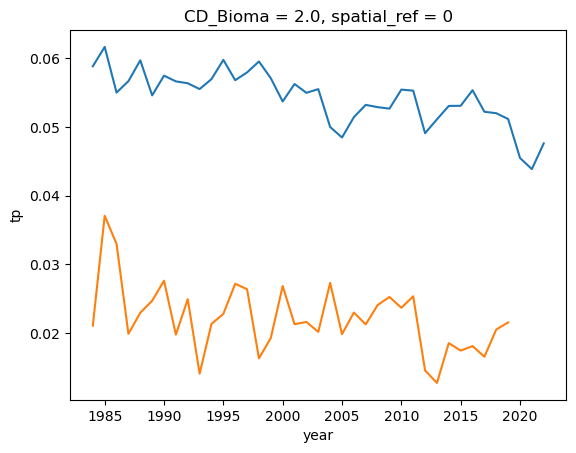

In [ ]:
# grouped_tp_reg_rainy_offset.where(grouped_tp_reg_rainy_offset.CD_Bioma!=2, drop=True)['tp'].mean(dim='CD_Bioma').groupby('valid_time.year').sum('valid_time').sel(year=slice(1984,2022)).plot.line(x='year')
grouped_tp_reg_rainy_offset.sel(CD_Bioma=2)['tp'].groupby('valid_time.year').sum('valid_time').sel(year=slice(1984,2019)).plot.line(x='year')

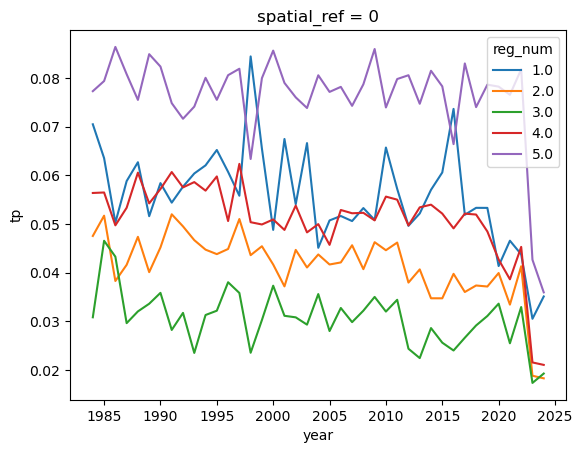

In [44]:
grouped_tp_reg_rainy_offset['tp'].groupby('valid_time.year').sum('valid_time').sel(year=slice(1984,2024)).plot.line(x='year')

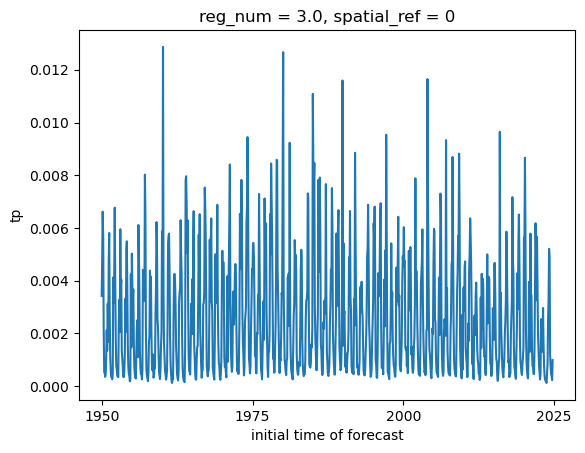

In [ ]:
grouped_tp_reg.sel(reg_num=3)['tp'].plot.line()

# Muni data:

In [4]:
muni_data = geopandas.read_file("../clip/brazil_munis_interviews.geojson")
muni_data['CD_MUN'] = muni_data['CD_MUN'].astype(int)

In [5]:

# temp = rioxarray.open_rasterio(
#     "./data/data_2.nc", masked=True
# )
# temp.rio.write_crs(4326, inplace=True)
# temp_clip = temp.rio.clip(
#     muni_data.geometry.values, muni_data.crs, from_disk=True
# )

In [6]:
precip_full = rioxarray.open_rasterio(
    "./data/precip_all.nc", masked=True
)
precip_full.rio.write_crs(4326, inplace=True)
precip_clip = precip_full.rio.clip(
    muni_data.geometry.values, muni_data.crs, from_disk=True
)

In [7]:
out_grid = make_geocube(
    vector_data=muni_data,
    measurements=["CD_MUN"],
    like=precip_clip, # ensure the data are on the same grid
)

In [8]:
out_grid["tp"] = (precip_clip.dims, precip_clip.values, precip_clip.attrs, precip_clip.encoding)

In [9]:
# temp_clip = temp_clip['t2m']
# out_grid["t2m"] = (temp_clip.dims, temp_clip.values, temp_clip.attrs, temp_clip.encoding)

In [10]:
grouped_tp = out_grid.drop("spatial_ref").groupby(out_grid.CD_MUN)

In [11]:
tp_mean =grouped_tp.mean()*30.5*1000

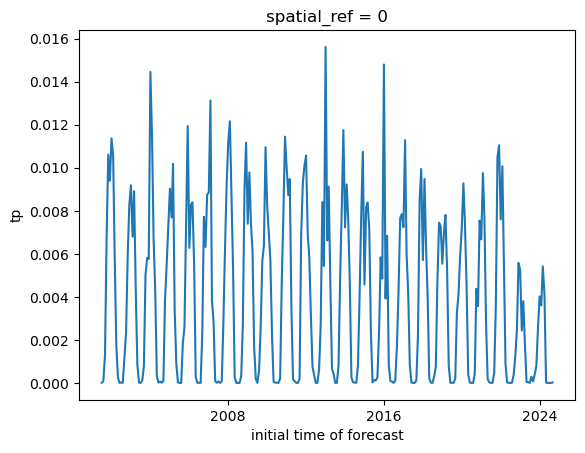

In [12]:
precip_clip.mean(dim=['y','x']).isel(valid_time=slice(-280,-1)).plot.line(x='valid_time')

In [13]:
tp_mean['valid_time'] = precip_clip['valid_time']
tp_mean = tp_mean.sortby('valid_time')
tp_mean_rainy_offset = tp_mean.copy()
tp_mean_rainy_offset['valid_time'] = (tp_mean.indexes['valid_time'].to_datetimeindex() + pd.DateOffset(months=+8)).values

/home/ksolvik/miniconda3/envs/resgis/lib/python3.10/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


In [69]:
# First print annual precip by muni
muni_annual_tp = tp_mean['tp'].groupby('valid_time.year').sum('valid_time').sel(year=slice(1991,2021)).groupby('CD_MUN').mean(dim='year')

muni_names_dict = {
    5101803: 'Barra do Garças',
    5102702: 'Canarana',
    5106257: 'Nova Xavantina',
    5107065: 'Querência',
}

for muni in muni_names_dict.keys():
    print(muni_names_dict[muni])
    print(muni_annual_tp.sel(CD_MUN=muni).values)

Barra do Garças
1801.7488
Canarana
1534.8479
Nova Xavantina
1534.557
Querência
1678.2493


In [58]:
tp_mean['tp'].groupby('valid_time.year').sum('valid_time').sel(year=slice(1970,2024)).groupby('CD_MUN').mean(dim='year').CD_MUN

<xarray.DataArray 'CD_MUN' (CD_MUN: 5)>
array([5100201., 5101803., 5102702., 5106257., 5107065.])
Coordinates:
  * CD_MUN       (CD_MUN) float64 5.1e+06 5.102e+06 ... 5.106e+06 5.107e+06
    spatial_ref  int64 0

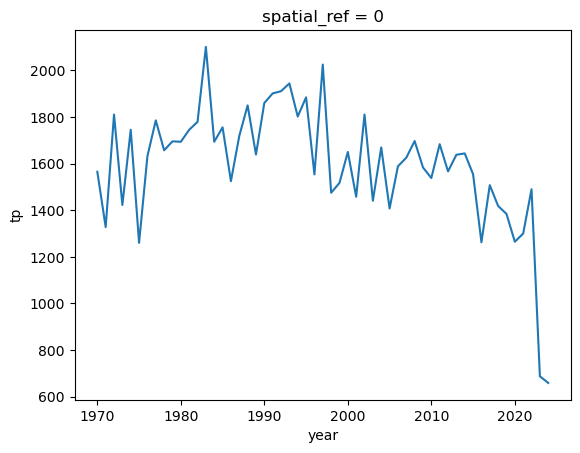

In [14]:
tp_mean_rainy_offset['tp'].mean(dim='CD_MUN').groupby('valid_time.year').sum('valid_time').sel(year=slice(1970,2024)).plot.line(x='year')

In [15]:
monthly_start =cftime.DatetimeProlepticGregorian(2019, 9, 1, 0, 0, 0, 0, has_year_zero=True)
monthly_end =cftime.DatetimeProlepticGregorian(2024, 9, 1, 0, 0, 0, 0, has_year_zero=True)
monthly_start_inset = 2020
monthly_end_inset = 2024
interview_time_start = cftime.DatetimeProlepticGregorian(2023, 8, 1, 0, 0, 0, 0, has_year_zero=True)
interview_time_end = cftime.DatetimeProlepticGregorian(2023, 10, 1, 0, 0, 0, 0, has_year_zero=True)


(0.0, 350.0)

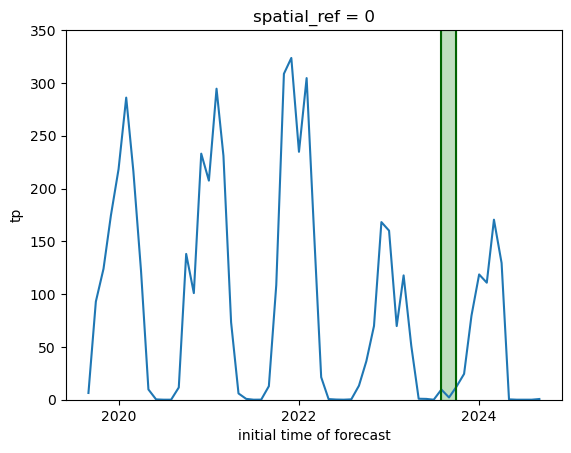

In [16]:
ax = tp_mean['tp'].mean(dim='CD_MUN').sel(valid_time=slice(monthly_start,monthly_end)).plot.line(x='valid_time')
monthly_end =cftime.DatetimeProlepticGregorian(2024, 9, 1, 0, 0, 0, 0, has_year_zero=True)

# Create data for the plot
y_lower = [0, 0]  # y-values for the lower boundary of shading
y_upper = [350, 350]  # y-values for the upper boundary of shading

# Plot the shading between the two vertical lines
plt.fill_between([interview_time_start, interview_time_end], y_lower, y_upper, color='green', alpha=0.25)
plt.axvline(interview_time_start,color='darkgreen')
plt.axvline(interview_time_end,color='darkgreen')
plt.ylim(0,350)

In [19]:

def read_process_region_csv(csv):
    temp_df = pd.read_csv(csv)
    temp_df['satellite'] = os.path.basename(csv)[:3]
    temp_df['year'] = int(os.path.basename(csv)[4:8])

    return temp_df

muni_csvs = glob.glob('../remove_bad_water/out/v3_interviews_only/*.csv')
muni_csvs.sort()
muni_list = [read_process_region_csv(csv) for csv in muni_csvs]
muni_df = pd.concat(muni_list)
# muni_df = muni_df.sort_index()

Text(0, 0.5, 'Total Reservoir Area (ha)')

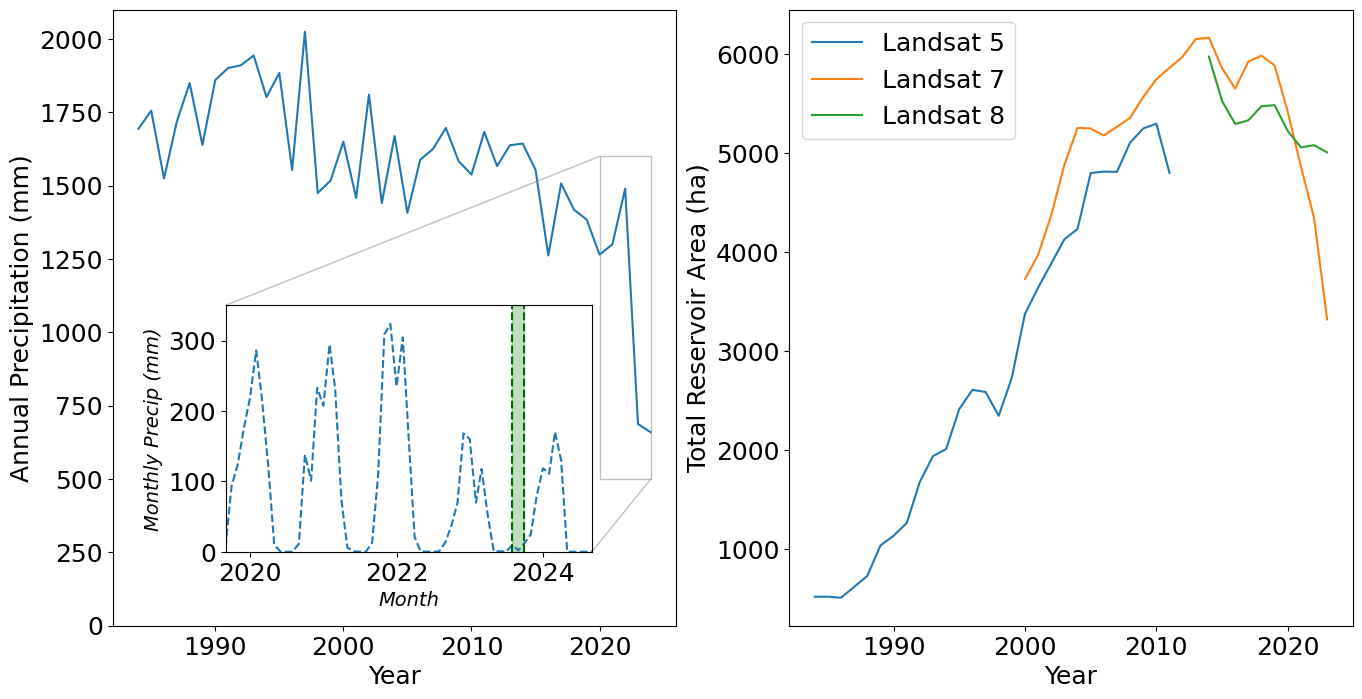

In [20]:
# Full Image
plt.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1, 2, figsize = (16, 8))

tp_mean_rainy_offset['tp'].mean(dim='CD_MUN'
                   ).groupby('valid_time.year'
                             ).sum('valid_time'
                                   ).sel(year=slice(1984,2024)
                                         ).plot.line(x='year', ax=axs[0])
axs[0].set_ylim(0, 2100)
# Creating inset
x1, x2, y1, y2 = monthly_start_inset, monthly_end_inset, 500, 1600   # Subregion of the original image
axins = axs[0].inset_axes(
    [0.2, 0.12, 0.65, 0.4],
    xlim=[monthly_start, monthly_end],ylim=[0,350])
tp_mean['tp'].mean(dim='CD_MUN'
                        ).sel(valid_time=slice(monthly_start,monthly_end)
                              ).plot.line(x='valid_time', ax=axins, linestyle='--')
axins.axvline(interview_time_start,linestyle='--',color='darkgreen')
axins.axvline(interview_time_end,linestyle='--',color='darkgreen')
axins.fill_between([interview_time_start, interview_time_end], y_lower, y_upper, color='green', alpha=0.25)
axs[0].indicate_inset((x1, y1, x2-x1, y2-y1), axins)
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Annual Precipitation (mm)')
axins.set_ylabel('Monthly Precip (mm)', size=14, style='italic')
axins.set_xlabel('Month', size=14, style='italic')
axins.set_title('')
axs[0].set_title('')


# Reservoir area
grouped_df = muni_df.groupby(['satellite','year']).sum()[['sum']]
for sat in ['ls5','ls7','ls8']:
    grouped_df.loc[sat].plot(ax=axs[1])
axs[1].legend(['Landsat 5','Landsat 7','Landsat 8'])

axs[1].set_xlabel('Year')
axs[1].set_ylabel('Total Reservoir Area (ha)')

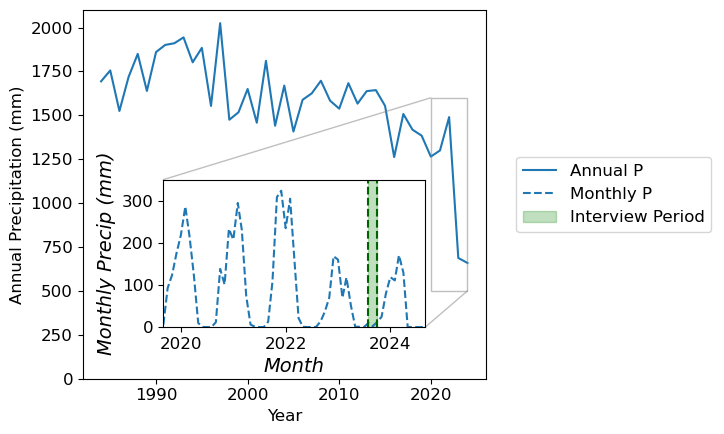

In [43]:

# Full Image
plt.rcParams.update({'font.size': 12})
axes_width_ratios=[1, 0.5]
fig, axs = plt.subplots(1, 2, figsize = (7.5, 4.5),
                       gridspec_kw={"width_ratios":axes_width_ratios})

tp_mean_rainy_offset['tp'].mean(dim='CD_MUN'
                   ).groupby('valid_time.year'
                             ).sum('valid_time'
                                   ).sel(year=slice(1984,2024)
                                         ).plot.line(x='year', ax=axs[0], label='Annual P')
axs[0].set_ylim(0, 2100)
# Creating inset
x1, x2, y1, y2 = monthly_start_inset, monthly_end_inset, 500, 1600   # Subregion of the original image
axins = axs[0].inset_axes(
    [0.2, 0.14, 0.65, 0.4],
    xlim=[monthly_start, monthly_end],ylim=[0,350])
tp_mean['tp'].mean(dim='CD_MUN'
                        ).sel(valid_time=slice(monthly_start,monthly_end)
                              ).plot.line(x='valid_time', ax=axins, linestyle='--', label='Monthly P')
axins.axvline(interview_time_start,linestyle='--',color='darkgreen')
axins.axvline(interview_time_end,linestyle='--',color='darkgreen')
axins.fill_between([interview_time_start, interview_time_end], y_lower, y_upper, color='green', alpha=0.25, label='Interview Period')
axs[0].indicate_inset((x1, y1, x2-x1, y2-y1), axins)
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Annual Precipitation (mm)')
axins.set_ylabel('Monthly Precip (mm)', size=14, style='italic')
axins.set_xlabel('Month', size=14, style='italic')
axins.set_title('')
axs[0].set_title('')


# Reservoir area
handles, labels = axs[0].get_legend_handles_labels()
handles2, labels2 = axins.get_legend_handles_labels()
handles = handles + handles2
labels = labels + labels2

axs[1].set_axis_off()
axs[1].legend(handles, labels, loc=10)
fig.tight_layout()

In [31]:
handles.append(handles2[0])

In [32]:
handles